In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)

data_train = pd.read_csv("Final_Data_Train_2.csv")
data_test = pd.read_csv("Final_Data_Test_2.csv")

In [6]:
data_train.head()

,Y,date,sentmon,sentyr,bookpost,trial,monsex,newcit,nocounts,drugcrime,...,MLB_Scored_GameNightBefore,MLB_GameNightBefore,CFB_Home/Away_GameThatNight,CFB_GameThatNight,CFB_Allowed_GameNightBefore,CFB_Home/Away_GameNightBefore,CFB_Margin_GameNightBefore,CFB_Result_GameNightBefore,CFB_Scored_GameNightBefore,CFB_GameNightBefore
0,-50.000000,0.210159,1.000000,0.20,0,0,0,1,0.002309,1,...,0.0,0,0,0,0,0,0,0,0,0
1,50.000000,0.328861,0.272727,0.35,0,1,0,1,0.006928,0,...,0.0,0,0,0,0,0,0,0,0,0
2,-50.000000,0.200575,0.818182,0.20,0,0,0,0,0.002309,0,...,0.0,0,0,0,0,0,0,0,0,0
3,-50.000000,0.371030,0.181818,0.40,0,0,0,0,0.002309,1,...,0.0,0,0,0,0,0,0,0,0,0
4,43.150685,0.395811,0.636364,0.40,0,0,0,0,0.004619,1,...,0.2,1,0,0,0,0,0,0,0,0


In [10]:
np.min(data_train['Y'])

-199.57142857099998

In [7]:
data_train.to_csv('Final_Data_Train_2.csv')
data_test.to_csv('Final_Data_Test_2.csv')

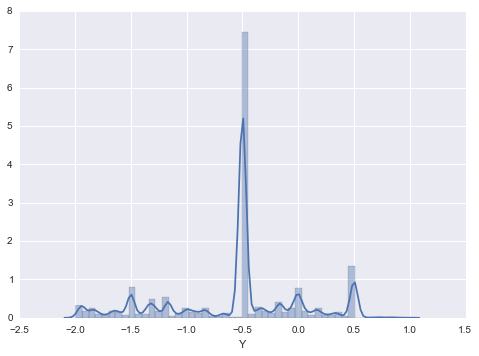

In [35]:
#Plot distribution of our new target variable (percentile of sentencing range) to make sure we don't have too many outliers 
x = np.random.normal(size=100)
x = data_train['Y']
sns.distplot(x);

In [27]:
#Test accuracy of Random Forest using different hyperparameters
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
dct = {}
min_samples = [9,17,25]
max_features = [0.3,0.4,0.6]
for sample in min_samples:
    for feature in max_features:  
        features = []
        RF_reg_final = RandomForestRegressor(n_estimators=100, min_samples_leaf = sample, max_features = feature, n_jobs = -1)
        RF_reg_final.fit(data_train.ix[:,1:], data_train.ix[:,0])
        feature_importance =  RF_reg_final.feature_importances_
        indices = np.argsort(feature_importance)[::-1][:15]
        err = mean_squared_error(data_test.ix[:,0], RF_reg_final.predict(data_test.ix[:,1:]))
        for f in range(15):
            features.append((data_test.ix[:,1:].columns.values[indices][f], feature_importance[indices[f]]))
        dct[(sample,feature)] = [features, err]


In [36]:
print '(min_samples_leaf, max_features)\t' 'mean_square_error'
for key in dct.keys():
    print '%s\t\t\t\t%f' % (key, dct[key][1])

(min_samples_leaf, max_features)	mean_square_error
(17, 0.4)				3079.007322
(17, 0.3)				3086.684900
(25, 0.4)				3109.444908
(25, 0.3)				3115.800323
(25, 0.6)				3105.021797
(9, 0.3)				3029.747156
(17, 0.6)				3075.258776
(9, 0.4)				3024.599612
(9, 0.6)				3022.947045


In [53]:
#Extract important features
feature_importance =  RF_reg_final.feature_importances_
indices = np.argsort(feature_importance)[::-1][:27]

feature_dct = {}
# Print the feature ranking
print("Feature ranking:")

for f in range(27):
    feature_dct[data_test.ix[:,1:].columns.values[indices][f]] = feature_importance[indices[f]]
feature_dct

Feature ranking:


{'MLB_Allowed_GameNightBefore': 0.010239991990823715,
 'crime_11.0': 0.010619514543661484,
 'crime_14.0': 0.017964660091281569,
 'crime_9.0': 0.015883997909072207,
 'crimetype_drug - trafficking': 0.01865358524615409,
 'crimetype_firearms': 0.012889858272815585,
 'crimetype_immigration': 0.018804694145152387,
 'date': 0.14770799978449875,
 'district_70': 0.011004503861802626,
 'district_74': 0.02995420506267223,
 'logprcp_mm': 0.021226701354747517,
 'logsun_min': 0.012731002125709301,
 'logtemp_max': 0.061684272291467918,
 'logtemp_min': 0.053828230057500571,
 'monsex': 0.022678190057524136,
 'newcit': 0.012659372513615305,
 'neweduc_1': 0.014351646613241897,
 'neweduc_3': 0.010300136016554988,
 'neweduc_5': 0.012690790705064981,
 'nocounts': 0.023268875452762249,
 'sentmon': 0.032759921395461446,
 'sentyr': 0.030484039859229872,
 'state_AZ': 0.012185647031123976,
 'state_CA': 0.02006333251355049,
 'state_NY': 0.010655763001885305,
 'state_TX': 0.016818557077059749,
 'trial': 0.0325914

In [70]:
from collections import OrderedDict
from operator import itemgetter

feature_dct = OrderedDict(sorted(feature_dct.items(), key=itemgetter(1), reverse = True))

In [65]:
neg_features = feature_dct.copy()
pos_features = feature_dct.copy()

#Use correlation matrix to determine which features are negatively correlated with our target variable
negs = ['date','sentyr','district_74','monsex','state_CA','crimetype_immigration',
       'crime_9.0','crime_14.0','newcit','crimetype_drug - trafficking','district_70',
       'MLB_Allowed_GameNightBefore','MLB_Scored_GameNightBefore','neweduc_5',
       'state_AZ']
for key in neg_features.keys():
    if key in negs:
        neg_features[key] = -neg_features[key]
    else:
        neg_features[key] = 0
for key in pos_features.keys():
    if key in negs:
        pos_features[key] = 0

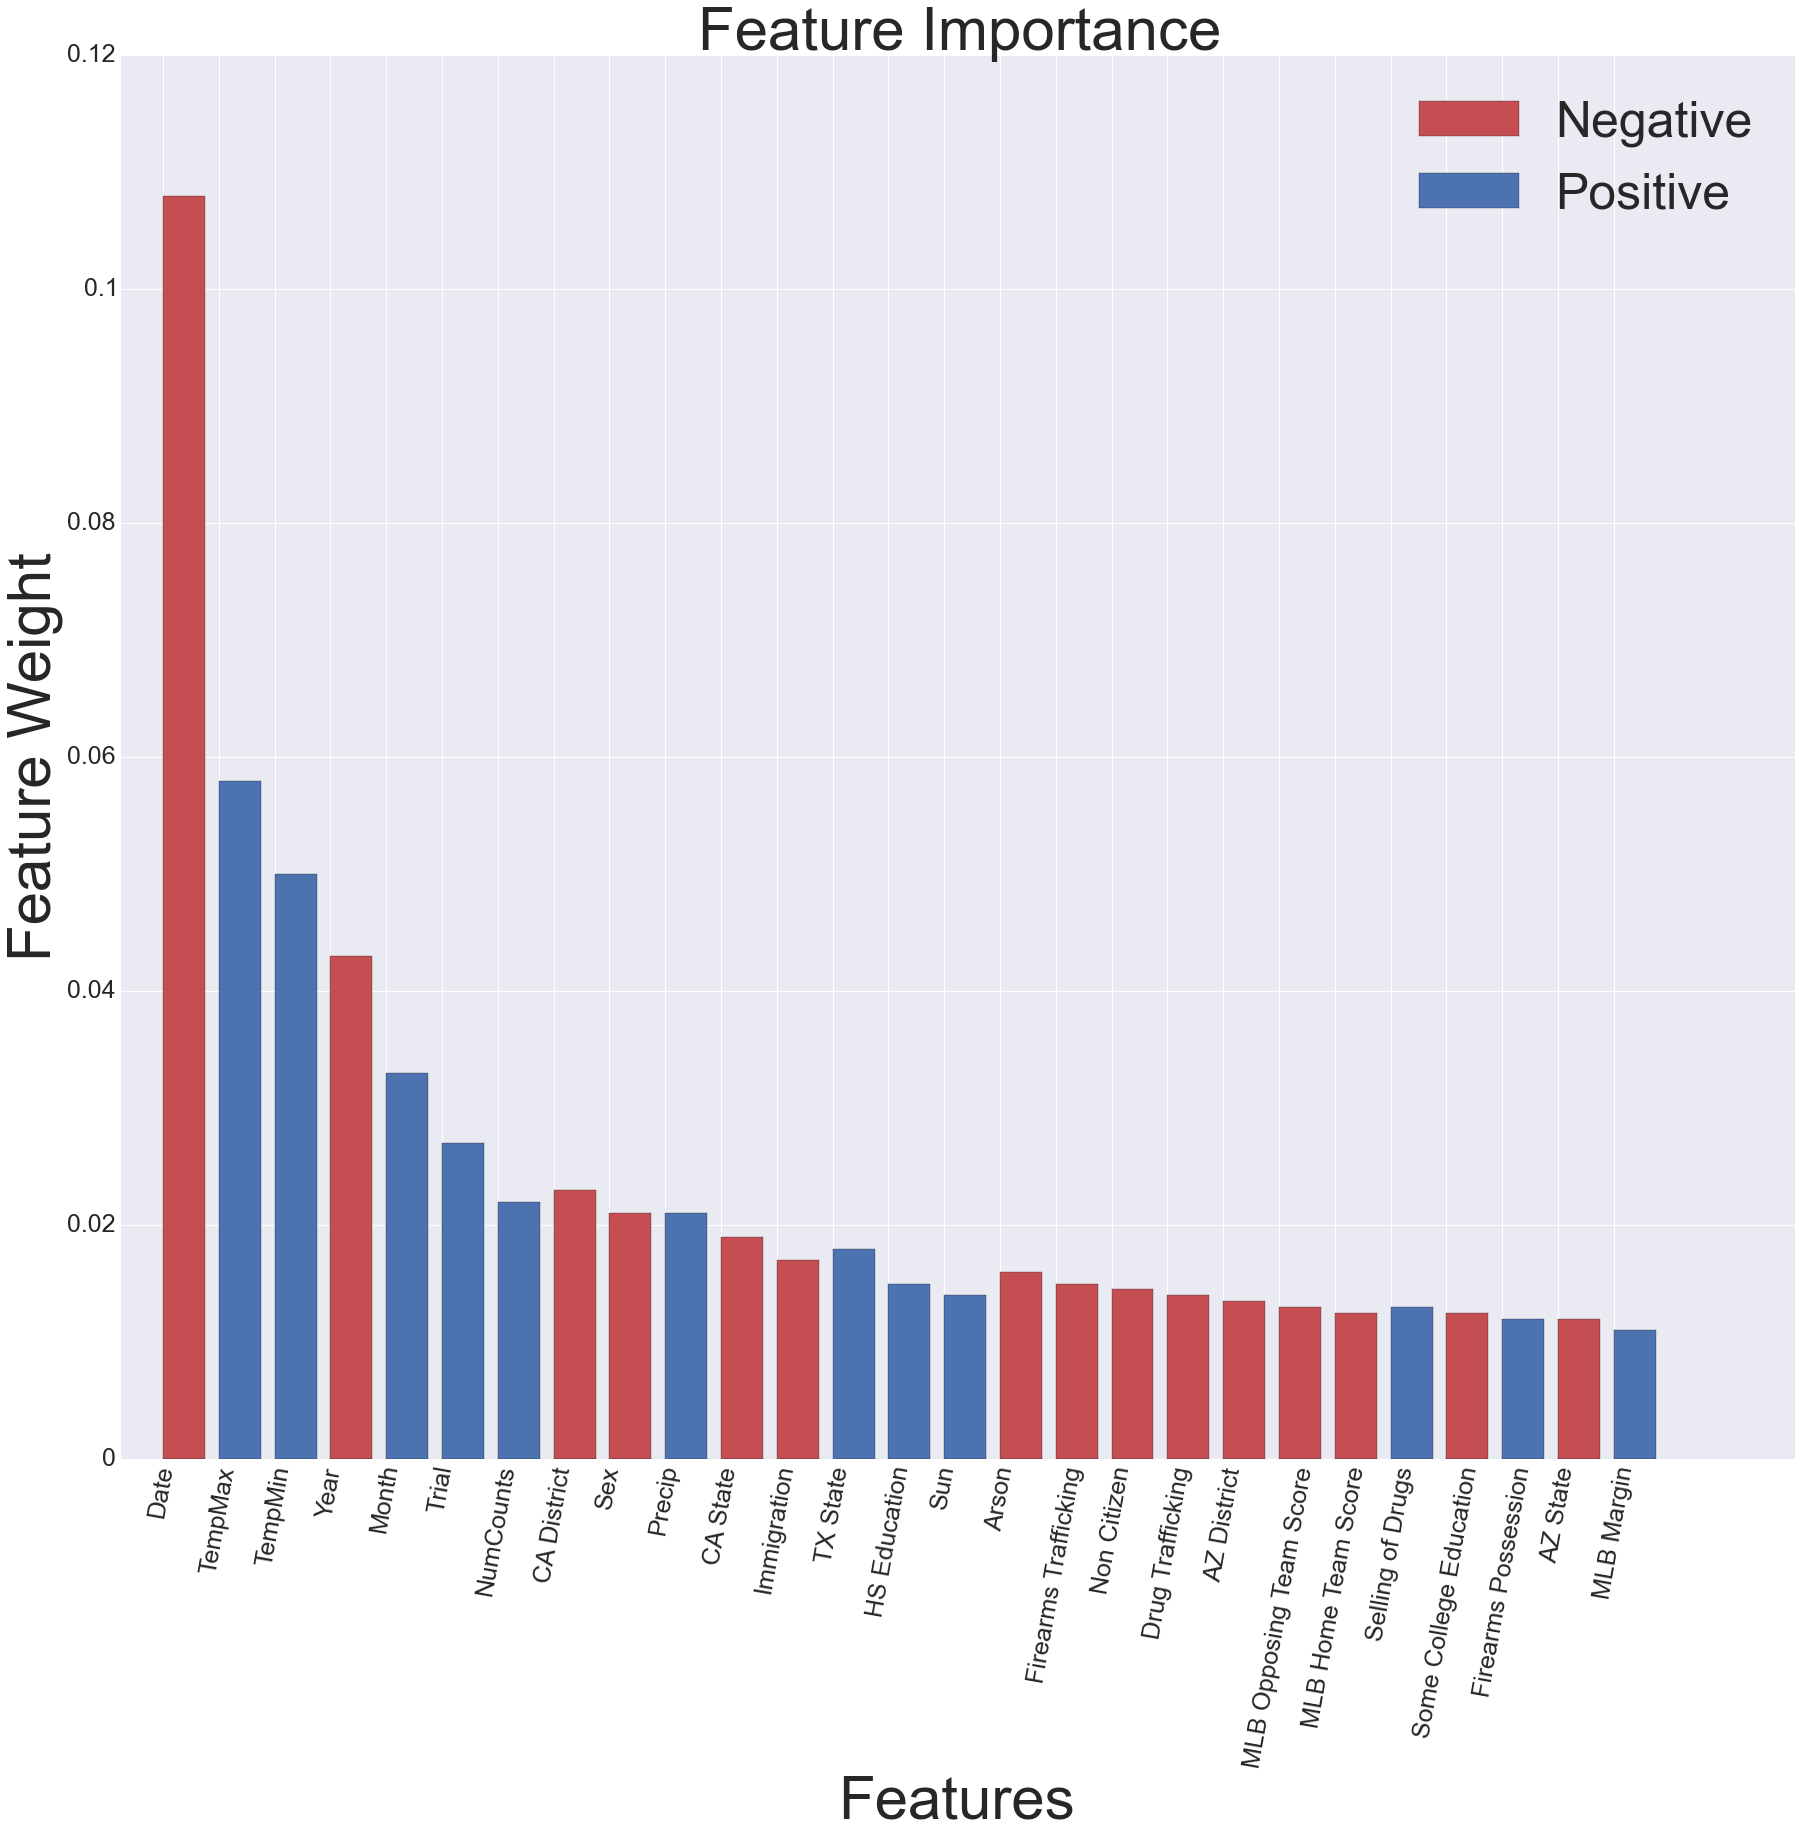

In [84]:
ind = np.arange(27)
width = 0.75

fig = plt.figure(facecolor = 'w', figsize = (30, 30))
ax = plt.subplot(111)
plt.subplots_adjust(bottom = 0.25)

rec = ax.bar(ind + width, np.abs(neg.values()), width, color='r', label = 'Negative')
rec = ax.bar(ind + width, pos.values(), width, color='b', label = 'Positive')
ax.set_ylabel('Feature Weight', fontsize = 60)
ax.set_title('Feature Importance', fontsize = 60)
ax.set_xticks(ind + width)
ax.set_xticklabels(pos.keys(), rotation = 80, fontsize = 25)
ax.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1,0.12],fontsize = 25)
ax.set_xlabel('Features', fontsize = 60)
ax.legend(fontsize = 50)
plt.show()

In [8]:
#Fit Gradient boosting to compare with RF
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


Drad_Boost_reg = GradientBoostingRegressor(n_estimators=100, loss='ls')
Drad_Boost_reg.fit(data_train.ix[:,1:], data_train.ix[:,0])

mse = mean_squared_error(data_test.ix[:,0], Drad_Boost_reg.predict(data_test.ix[:,1:]))
print 'Mean_squared_error', mse

Mean_squared_error 3352.61996239


In [10]:
#Fit linear regression to compare with RF
from sklearn import linear_model 

regr = linear_model.LinearRegression()
regr.fit(data_train.ix[:,1:], data_train.ix[:,0])
mse = mean_squared_error(data_test.ix[:,0], regr.predict(data_test.ix[:,1:]))
print 'Mean_squared_error', mse

Mean_squared_error 3368.99857407


In [12]:
#Fit RF with default hyperparameters
from sklearn.ensemble import RandomForestRegressor

RF_reg_final = RandomForestRegressor(n_estimators=100, n_jobs = -1)
RF_reg_final.fit(data_train.ix[:,1:], data_train.ix[:,0])
print mean_squared_error(data_test.ix[:,0], RF_reg_final.predict(data_test.ix[:,1:]))

2941.22288439


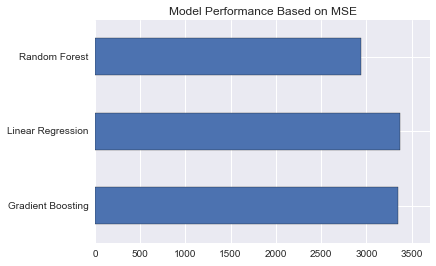

In [24]:
from pylab import *

mse = [3352.61996239, 3368.99857407, 2941.22288439]
pos = arange(3)+.5     # the bar centers on the y axis
figure(1)
barh(pos,mse, align='center',height = 0.5)
plt.xlim([0,3700])
yticks(pos, ('Gradient Boosting','Linear Regression','Random Forest'))
title('Model Performance Based on MSE')
grid(True)
show()